In [6]:
import sys
import numpy as np
import math
from scipy import sparse
import ceo
%pylab inline
%run GMT_DOS_SAO.py

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [7]:
nPx = 101
print "pupil sampling:      %d pixel"%nPx
detectorRes = 2.0*N_PX_LENSLET*N_LENSLET/2.0
print "detector resolution: %d pixel"%detectorRes
gmt = ceo.GMT_MX(entrance_pupil_size_meter,nPx,
                 M1_radial_order=7,
                 M2_radial_order=7)


pupil sampling:      101 pixel
detector resolution: 468 pixel


In [8]:
def putM1Shape(modes=np.arange(1,8),stroke=np.ones(7)):
    for k in range(7):
        gmt.M1.zernike.a[k,modes[k]] = stroke[k]*1e-6
    gmt.M1.zernike.update()
def putM2Shape(modes=np.arange(1,8),stroke=np.ones(7)):
    for k in range(7):
        gmt.M2.zernike.a[k,modes[k]] = stroke[k]*1e-6
    gmt.M2.zernike.update()
def putShapes(modesM1=np.arange(1,8),strokeM1=np.ones(7),
              modesM2=np.arange(1,8),strokeM2=np.ones(7)):
    putM1Shape(modes=modesM1,stroke=strokeM1)
    putM2Shape(modes=modesM2,stroke=strokeM2)

## On-axis source

In [9]:
gs0 = ceo.Source(AGWS_photometric_band,
                   zenith=0,
                    azimuth=0,
                   rays_box_size=entrance_pupil_size_meter,
                   rays_box_sampling=nPx,rays_origin=[0.0,0.0,25],
                  magnitude=15,fwhm=10.6)
gmt.reset()
gmt.propagate(gs0)
P0_gs0 = gs0.wavefront.phase.host(units='micron')

### On-axis wavefront M1 shape only

In [10]:
gmt.reset()
#M1modes = np.arange(1,8)
M1modes = np.random.randint(1,29,7)
#M1stroke = np.ones(7)
M1stroke = (np.random.rand(7)*2-1)
putM1Shape(modes=M1modes,stroke=M1stroke)
gs0.reset()
gmt.propagate(gs0)
P_gs0_1 = gs0.wavefront.phase.host(units='micron') - P0_gs0

### On-axis wavefront M2 shape only

In [11]:
gmt.reset()
#M2modes = np.arange(1,8)
M2modes = np.random.randint(1,29,7)
#M2stroke = np.ones(7)
M2stroke = (np.random.rand(7)*2-1)
putM2Shape(modes=M2modes,stroke=M2stroke)
gs0.reset()
gmt.propagate(gs0)
P_gs0_2 = gs0.wavefront.phase.host(units='micron') - P0_gs0

<matplotlib.colorbar.Colorbar instance at 0x2b20ff148248>

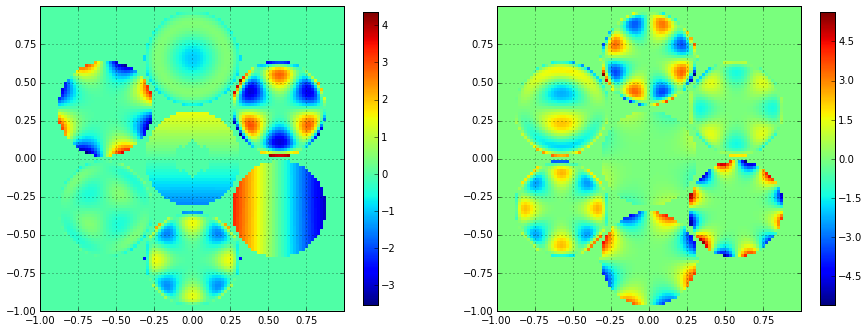

In [12]:
fig, (ax1,ax2) = subplots(ncols=2)
fig.set_size_inches(15,15)
h1 = ax1.imshow(P_gs0_1.reshape(nPx,nPx),interpolation='none',origin='lower',extent=[-1,1,-1,1])
ax1.grid()
ax1.set_xticks(np.arange(-1,1,0.25))
ax1.set_yticks(np.arange(-1,1,0.25))
colorbar(h1,ax=ax1,shrink=0.35)
h2 = ax2.imshow(P_gs0_2.reshape(nPx,nPx),interpolation='none',origin='lower',extent=[-1,1,-1,1])
ax2.grid()
ax2.set_xticks(np.arange(-1,1,0.25))
ax2.set_yticks(np.arange(-1,1,0.25))
colorbar(h2,ax=ax2,shrink=0.35)


### On-axis wavefront both M1 and M2 shapes

<matplotlib.colorbar.Colorbar instance at 0x2b20ff69a128>

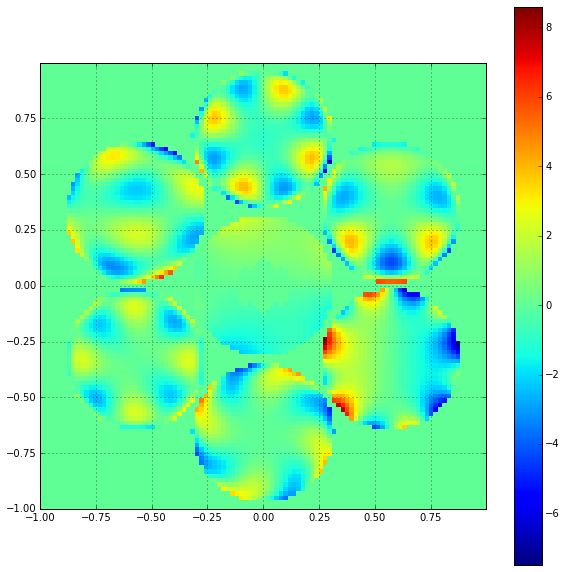

In [13]:
gmt.reset()
putShapes(modesM1=M1modes,strokeM1=M1stroke,
          modesM2=M2modes,strokeM2=M2stroke)
gs0.reset()
gmt.propagate(gs0)
A_gs0 = gs0.wavefront.amplitude.host()
P_gs0 = gs0.wavefront.phase.host(units='micron') - P0_gs0
fig, ax = subplots()
fig.set_size_inches(10,10)
h = ax.imshow(P_gs0.reshape(nPx,nPx),interpolation='none',origin='lower',extent=[-1,1,-1,1])
ax.grid()
ax.set_xticks(np.arange(-1,1,0.25))
ax.set_yticks(np.arange(-1,1,0.25))
colorbar(h,ax=ax)

In [14]:
try:
    vmin = np.min(P_gs0[P_gs0!=0])
    vmax = np.max(P_gs0[P_gs0!=0])
except:
    vmin = 0
    vmax = 0

## Off-axis source

In [15]:
N_GS = 3
gs = [ceo.Source(AGWS_photometric_band,
                   zenith=8*ceo.constants.ARCMIN2RAD,
                    azimuth=2*k*math.pi/3,
                   rays_box_size=entrance_pupil_size_meter,
                   rays_box_sampling=nPx,rays_origin=[0.0,0.0,25],
                  magnitude=15,fwhm=10.6) for k in range(N_GS)]

In [16]:
[x.reset() for x in gs]
gmt.reset()
[gmt.propagate(x) for x in gs]
P0 = [x.wavefront.phase.host(units='micron').ravel() for x in gs]
putShapes(modesM1=M1modes,strokeM1=M1stroke,
          modesM2=M2modes,strokeM2=M2stroke)
[x.reset() for x in gs]
[gmt.propagate(x) for x in gs]
Pm = [gs[k].wavefront.phase.host(units='micron').ravel()-P0[k] for k in range(N_GS)]
Am = [gs[k].wavefront.amplitude.host() for k in range(N_GS)]
#imshow(np.concatenate(Pm,axis=2).reshape(3*nPx,nPx).T,shape=(nPx,nPx),interpolation='none')

###  M1 Identity operator & Bilinear Interpolation

In [17]:
A_GS   = []
bli_GS = []
M2_h = 20.26247617
for k in range(N_GS):
    x = (8.365/1.0415)*M2_h*np.tan( gs[k].zenith )*np.cos( gs[k].azimuth )*nPx/float(entrance_pupil_size_meter)
    y = (8.365/1.0415)*M2_h*np.tan( gs[k].zenith )*np.sin( gs[k].azimuth )*nPx/float(entrance_pupil_size_meter)
    print x,y
    bli_GS.append( ceo.BilinearInterpolation(nPx,nPx,gs[k].wavefront,i0=y,j0=x) )
    A_GS.append( sparse.spdiags(gs[k].wavefront.amplitude.host(),0,nPx**2,nPx**2) )

[ 1.47117424] [ 0.]
[-0.73558718] [ 1.27407432]
[-0.735587] [-1.27407432]


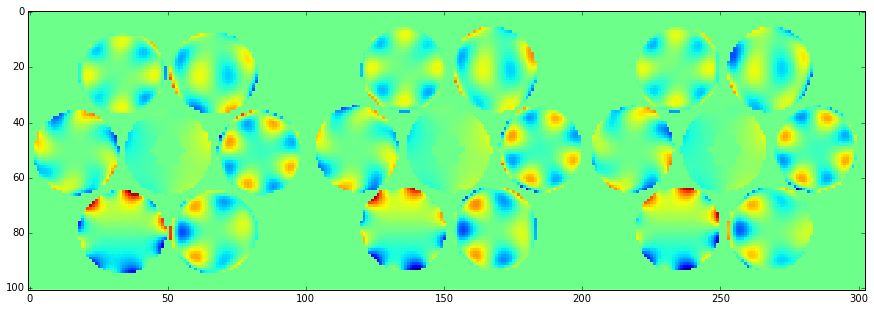

In [18]:
R = entrance_pupil_size_meter/2
Pm_gs = np.concatenate(Pm)
Am_gs = np.concatenate(Am)
fig = figure()
fig.set_size_inches((15,10))
imshow(Pm_gs.reshape((N_GS*nPx,nPx)).T,interpolation='none')

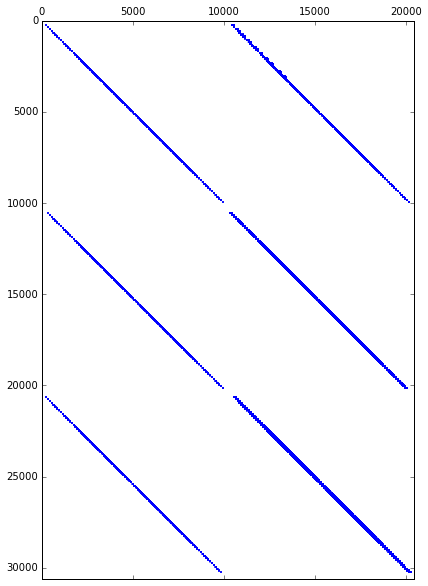

In [19]:
A = sparse.vstack([A_GS[k] for k in range(N_GS)])
B = sparse.vstack([bli_GS[k].H for k in range(N_GS)])
Q = sparse.hstack([A,B])
fig = figure()
fig.set_size_inches(10,10)
spy(Q,marker='.',markersize=1)

<matplotlib.colorbar.Colorbar instance at 0x2b2108381998>

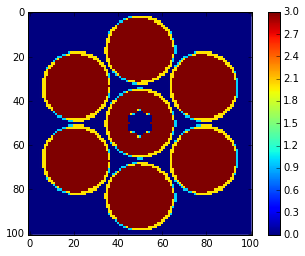

In [20]:
imshow(Am_gs.sum(axis=0).reshape(nPx,nPx),interpolation='none')
colorbar()

<matplotlib.colorbar.Colorbar instance at 0x2b21084ce128>

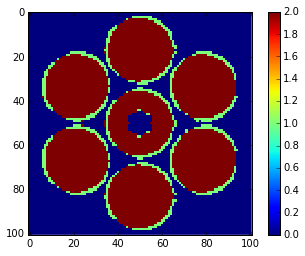

In [21]:
imshow(Am_gs.sum(axis=0).reshape(nPx,nPx)-gs0.amplitude.host(),interpolation='none')
colorbar()

## M1 & M2 shape estimation

In [22]:
S = sparse.linalg.lsqr(Q,Pm_gs)
P12 = S[0]
nel = nPx**2

### M1 & M1 shapes

<matplotlib.colorbar.Colorbar instance at 0x2b21089717a0>

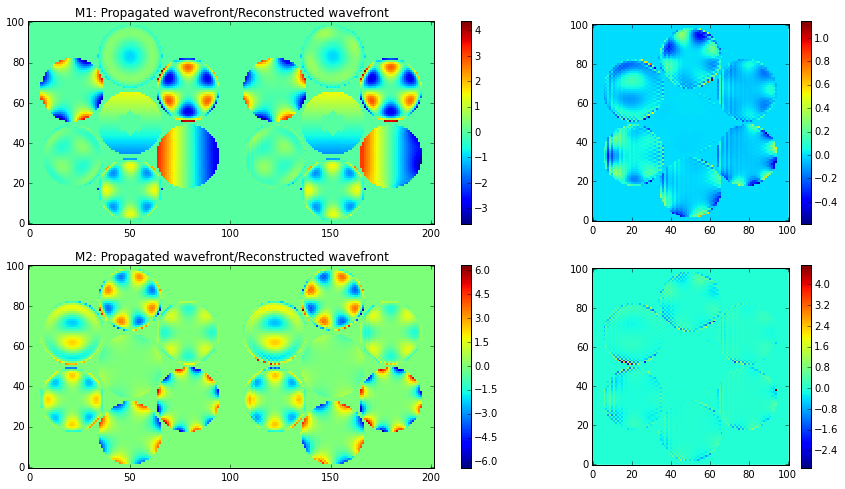

In [23]:
fig = figure()
fig.set_size_inches(15,8)
ax1 = subplot2grid((2,3), (0,0), colspan=2)
P_gs0_1_est = A_gs0*P12[:nel]
h1 = ax1.imshow(np.concatenate((P_gs0_1.reshape(nPx,nPx),P_gs0_1_est.reshape(nPx,nPx)),axis=1),
                interpolation='none',origin='lower')
colorbar(h1,ax=ax1)
ax1.set_title("M1: Propagated wavefront/Reconstructed wavefront")
Pres_1 = P_gs0_1_est - P_gs0_1
ax2 = subplot2grid((2,3), (0,2))
h2 = ax2.imshow(Pres_1.reshape(nPx,nPx),
                interpolation='none',origin='lower')
colorbar(h2,ax=ax2)
ax3 = subplot2grid((2,3), (1,0), colspan=2)
P_gs0_2_est = A_gs0*P12[nel:]
h3 = ax3.imshow(np.concatenate((P_gs0_2.reshape(nPx,nPx),P_gs0_2_est.reshape(nPx,nPx)),axis=1),
                interpolation='none',origin='lower')
colorbar(h3,ax=ax3)
ax3.set_title("M2: Propagated wavefront/Reconstructed wavefront")
Pres_2 = P_gs0_2_est - P_gs0_2
ax4 = subplot2grid((2,3), (1,2))
h4 = ax4.imshow(Pres_2.reshape(nPx,nPx),
                interpolation='none',origin='lower')
colorbar(h4,ax=ax4)

### M1+M2 shape

In [24]:
P_gs0_est = A_gs0*P12.reshape(2,-1).sum(axis=0)
Pres = P_gs0_est - P_gs0
print "WFE=%.2fnm"%(np.std(Pres[A_gs0==1])*1e3)
print "WFE rejection ratio=%.2f%%"%(100*np.std(P_gs0[A_gs0==1])/np.std(Pres[A_gs0==1]))

WFE=214.97nm
WFE rejection ratio=733.80%


<matplotlib.colorbar.Colorbar instance at 0x2b2108c80998>

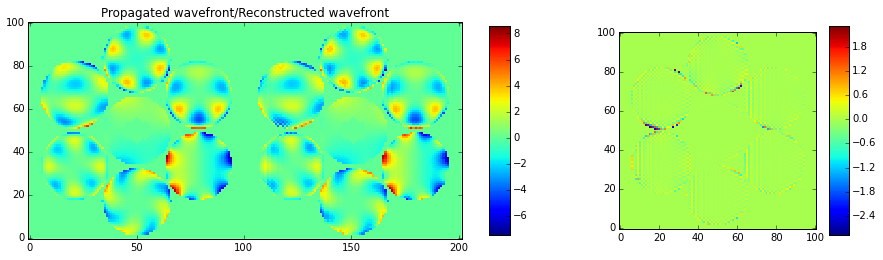

In [25]:
fig = figure()
fig.set_size_inches(15,15)
ax1 = subplot2grid((1,3), (0,0), colspan=2)
h1 = ax1.imshow(np.concatenate((P_gs0.reshape(nPx,nPx),P_gs0_est.reshape(nPx,nPx)),axis=1),
                interpolation='none',origin='lower')
colorbar(h1,ax=ax1,shrink=.25,aspect=10)
ax1.set_title("Propagated wavefront/Reconstructed wavefront")
ax2 = subplot2grid((1,3), (0,2))
h2 = ax2.imshow(Pres.reshape(nPx,nPx),
                interpolation='none',origin='lower')
colorbar(h2,ax=ax2,shrink=.25,aspect=10)